In [1]:
import pandas as pd
pd.options.display.max_rows = 1000

import pickle

import numpy as np

import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [2]:
with open('../data/interim/02_cleaned.pkl', 'rb') as picklefile:
    df_listings = pickle.load(picklefile)

In [4]:
df_listings['neighborhood'].head()

0    OUTSIDE ZILLOW
1    OUTSIDE ZILLOW
2    OUTSIDE ZILLOW
3    OUTSIDE ZILLOW
4    OUTSIDE ZILLOW
Name: neighborhood, dtype: object

In [5]:
df_listings = df_listings[df_listings['neighborhood'] != 'OUTSIDE ZILLOW']

In [6]:
len(df_listings)

85033

#### Preprocess neighborhood overviews for topic modeling

In [7]:
num_punct = string.punctuation
num_punct.replace("'", "")
num_punct += '0123456789'

In [8]:
df_listings.loc[:,'lower'] = df_listings['neighborhood_overview'].map(lambda s: s.lower().translate(None, num_punct).decode('utf-8').split())

In [9]:
test = df_listings['lower'][864]
test

[u'although',
 u'we',
 u'are',
 u'close',
 u'to',
 u'downtown',
 u'we',
 u'are',
 u'tucked',
 u'away',
 u'on',
 u'a',
 u'quiet',
 u'street',
 u'which',
 u'makes',
 u'this',
 u'a',
 u'true',
 u'urban',
 u'oasis']

In [10]:
neighborhood_stopwords = []
for neighborhood in df_listings['neighborhood'].drop_duplicates().tolist()[1:]:
    neighborhood_stopwords.extend(neighborhood.encode('utf-8').lower().translate(None, num_punct).split())

In [11]:
location_stopwords = neighborhood_stopwords + \
                    ['san', 'francisco', 'diego', 'los', 'angeles', 'santa', 'monica', \
                    'new', 'york', 'city', 'nyc', 'orleans', 'chicago', 'boston', 'nashville', \
                    'washington', 'dc', 'denver', 'portland', 'oakland', 'austin', 'seattle', \
                    'california', 'washington', 'massachusetts', 'oregon', 'northwest', \
                    'pacific', 'northeast', 'texas', 'hollywood', 'height', 'silverlake', 'griffith', \
                    'alberta', 'willamette', 'mississipii', 'powell', 'barclays', 'bed', 'stuy', 'bedstuy',\
                    'hell', 'kitchen', 'pasadena', 'franciscos', 'diegos', 'barclays', 'sf', 'haight', 
                    'bart', 'divisadero', 'nopa', 'smithsonian', 'adam', 'mall', 'dcs', 'tulane', \
                    'loyola', 'bourbon', 'ca', 'ny', 'ma', 'co', 'wa', 'or', 'la', 'wa', 'tx', \
                    'il', 'chi', 'bos', 'tn']

In [12]:
location_stopwords[-10:]

['co', 'wa', 'or', 'la', 'wa', 'tx', 'il', 'chi', 'bos', 'tn']

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
decoded_stopwords = [s.decode('utf-8') for s in location_stopwords]
stopwords.extend(decoded_stopwords)

In [14]:
stopwords[:10], stopwords[-10:]

([u'i',
  u'me',
  u'my',
  u'myself',
  u'we',
  u'our',
  u'ours',
  u'ourselves',
  u'you',
  u'your'],
 [u'co', u'wa', u'or', u'la', u'wa', u'tx', u'il', u'chi', u'bos', u'tn'])

In [15]:
lemmatizer = WordNetLemmatizer()
lemma_pos = {'JJ': 'a',
             'NN': 'n',
             'RB': 'r', 
             'VB': 'v'}

def lemmatize(word_list):
    lemmas = []
    pos_tags = pos_tag(word_list)
    #print pos_tags
    for word, pos in pos_tags:
        #print word, pos
        #remove proper nouns
        if pos != 'NNP' and pos != 'NNPS':
            try:
                p = lemma_pos[pos[:2]]
                lemma = lemmatizer.lemmatize(word, pos=p)
                #remove stopwords
                if lemma not in stopwords:
                    lemmas.append(lemma)
            except:
                continue
    return lemmas

In [16]:
%%timeit
lemmatize(test)

The slowest run took 1820.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.58 ms per loop


In [17]:
%%time
df_listings.loc[:,'lemmas'] = df_listings['lower'].map(lambda lst: lemmatize(lst))

CPU times: user 10min 50s, sys: 4.99 s, total: 10min 55s
Wall time: 10min 55s


In [18]:
with open('../data/interim/04_lemmas.pkl', 'wb') as picklefile:
    pickle.dump(df_listings, picklefile)

#### Create dataframes for clustering on neighborhoods and cities

In [19]:
with open('../data/interim/04_lemmas.pkl', 'rb') as picklefile:
    df_listings = pickle.load(picklefile)

In [20]:
df_descriptions = df_listings.groupby(['neighborhood', 'city', 'state'])['lemmas'].apply(lambda lst: [' '.join(x) for x in lst]).reset_index()
df_descriptions['lemmas'] = df_descriptions['lemmas'].apply(lambda x: ' '.join(x))

In [21]:
df_descriptions.head(10)

,neighborhood,city,state,lemmas
0,Abbington Park Condos,nashville,TN,locate safe familyfriendly also minute car ri...
1,Abbot Martin Estates,nashville,TN,
2,Acklen Avenue Alliance,nashville,TN,location restaurant shop boutique offer need r...
3,Acorn,oakland,CA,
4,Adams Hill,losangeles,CA,safe walkable shop metro bus friendly neighbor...
5,Adams Morgan,washingtondc,DC,walkability coffee grocery din shopping gy...
6,Adams North,sandiego,CA,renaissance recent year lot restaurant nearby ...
7,Adams Point,oakland,CA,restaurant whole food supermarket beauty ...
8,Adams-Normandie,losangeles,CA,rich culture history win highly coveted year c...
9,Admiral,seattle,WA,make stretch puget sound best setting national...


In [22]:
df_counts = df_listings.groupby(['neighborhood', 'city', 'state']).count()['id'].reset_index()
df_counts.rename(columns={'id': 'num_listings'}, inplace=True)
df_counts.head(10)

,neighborhood,city,state,num_listings
0,Abbington Park Condos,nashville,TN,2
1,Abbot Martin Estates,nashville,TN,1
2,Acklen Avenue Alliance,nashville,TN,5
3,Acorn,oakland,CA,1
4,Adams Hill,losangeles,CA,9
5,Adams Morgan,washingtondc,DC,185
6,Adams North,sandiego,CA,26
7,Adams Point,oakland,CA,33
8,Adams-Normandie,losangeles,CA,36
9,Admiral,seattle,WA,39


In [23]:
df_neighborhoods = df_descriptions.merge(df_counts)

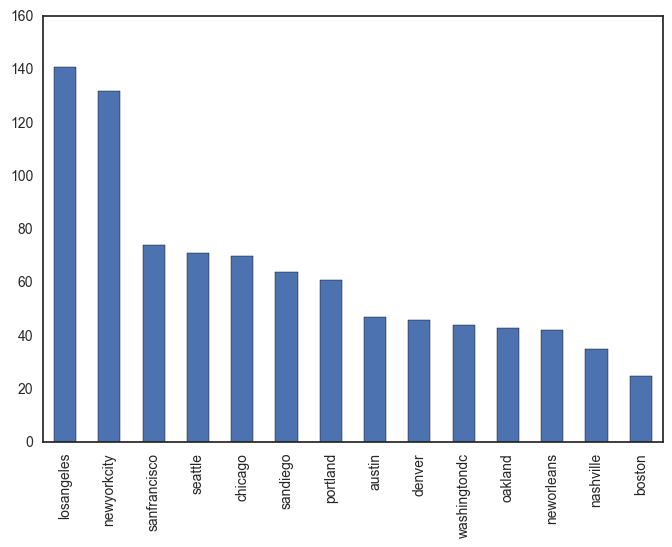

In [24]:
df_neighborhoods[df_neighborhoods['num_listings'] >= 10]['city'].value_counts().plot(kind='bar');

In [25]:
df_neighborhoods = df_neighborhoods[df_neighborhoods['num_listings'] >= 10]

In [26]:
with open('../data/interim/04_neighborhoods.pkl', 'wb') as picklefile:
    pickle.dump(df_neighborhoods, picklefile)

In [ ]:
descriptions = df_neighborhoods['lemmas'].tolist()

In [ ]:
len(descriptions)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import linkage, ward, dendrogram

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                   min_df=2,
                                   max_features=1000,
                                   stop_words=stopwords, 
                                   ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(descriptions).toarray()
tfidf_features = tfidf_vectorizer.get_feature_names()

In [ ]:
#10 words with highest tfidf
top = tfidf_vectorizer.idf_.argsort()[:10].tolist()
[(tfidf_features[i], tfidf_vectorizer.idf_[i]) for i in top]

In [ ]:
#10 words with lowest tfidf
bottom = tfidf_vectorizer.idf_.argsort()[::-1].tolist()[:10]
[(tfidf_features[i], tfidf_vectorizer.idf_[i]) for i in bottom]

In [ ]:
tfidf.shape

In [ ]:
#cities = df_cities_grouped['city'].tolist()
neighborhoods = df_neighborhoods['neighborhood'].tolist()
cities = df_neighborhoods['city'].tolist()
states = df_neighborhoods['state'].tolist()

In [ ]:
zipped = zip(neighborhoods, cities, states)

In [ ]:
terms = tfidf_vectorizer.get_feature_names()

In [ ]:
dist = 1 - cosine_similarity(tfidf)
linkage_matrix = ward(dist)

In [ ]:
linkage_matrix = linkage(dist, method='complete', metric='cosine')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 100)) # set size
dend = dendrogram(linkage_matrix,
                p=12,
                #truncate_mode='lastp', 
                labels=zipped,
                orientation='left');

ax = dend

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=300) #save figure as ward_clusters

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [ ]:
db = DBSCAN(metric='cosine', algorithm='brute').fit(tfidf)

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)